In [81]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans

In [82]:
def load_images(root_path, file_names, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

def flat_image(image):
    """
    Aplana una imagen a una lista de píxeles de tres dimensiones.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    """
    return image.reshape((-1, 3))

In [83]:
root_path = 'data'

In [84]:
img_files = os.listdir(root_path)
img_files

['img2.jpg', 'img5.jpg', 'img1.jpg', 'img3.jpg', 'img4.jpg']

In [85]:
# Cargar imágenes
img_list = load_images(root_path, img_files, normalize=True)


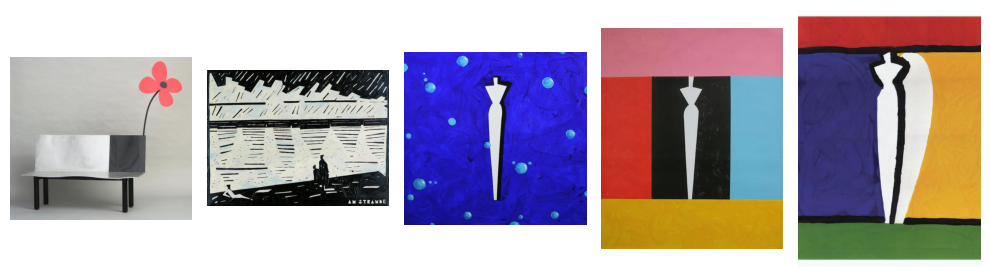

In [86]:
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img_list[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [87]:
image_number = input('Ingrese el número de la imagen que desea analizar: ')
image_number = int(image_number)
image_number

2

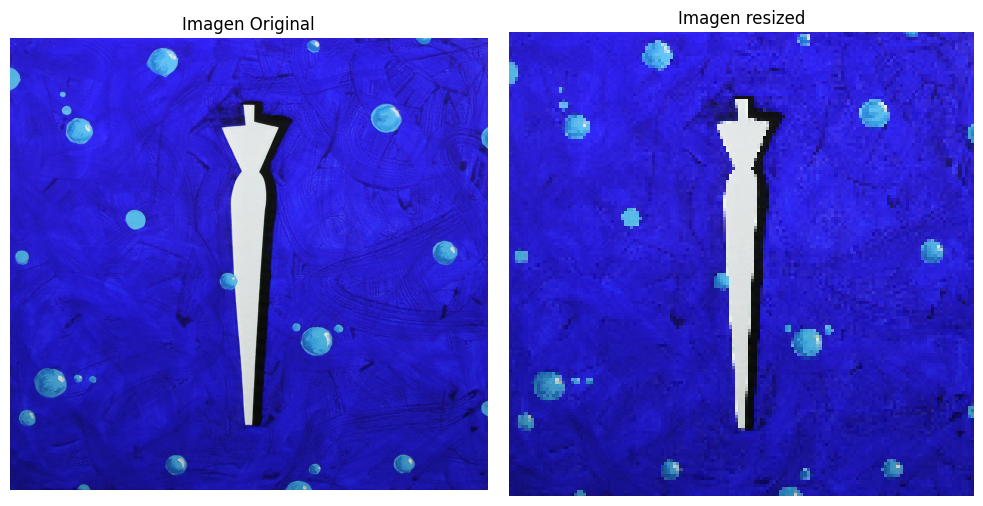

In [88]:
# Resize image
img_resized = cv2.resize(img_list[image_number], (150, 150))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_list[image_number])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen resized')
plt.imshow(img_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

In [89]:
img_original_flatten = flat_image(img_list[image_number])
img_original_flatten.shape

(2019102, 3)

In [90]:
img_resized_flatten = flat_image(img_resized)
img_resized_flatten.shape

(22500, 3)

In [91]:
def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

In [92]:
# elbow_plot(img_resized_flatten, "kmeans")

In [93]:
from deco import synchronized, concurrent

In [94]:
@concurrent
def train(X, k, model):
    """
    Entrena un modelo de clustering
    
    Parametros:
    X : np.array
        El arreglo con los datos
    k : int
        Número de clusters
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    """
    if model == "kmeans":
        model_k = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
    else:
        model_k = KMedoids(n_clusters=k, max_iter=300, random_state=0)
    # Entrenamos el modelo
    model_k.fit(X)
    score = silhouette_score(X, model_k.labels_)
    return score

In [95]:
@synchronized
def silhouette_plot(X, model, k_min=4, k_max=8):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = {}
    for i in range(k_min, k_max+1):
        scores[i] = train(X, i, model)
    
    # Graficamos los valores del coeficiente de la silueta
    return scores

In [96]:
# scores = silhouette_plot(img_resized_flatten, "kmeans")
# plt.plot(range(4,9), scores, marker='o')
# plt.xlabel('Número de clusters')
# plt.ylabel('Silhouette Score')
# plt.grid()
# plt.show()

In [97]:
scores = {4: 0.7296670621255464, 5: 0.846750390737681, 6: 0.875867464433454, 7: 0.8293969553951684, 8: 0.7584781804540308}

In [98]:
num_clusters = max(scores, key=lambda k: scores.get(k))
num_clusters

6

In [99]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(img_resized_flatten)

/home/jordineil/Documents/maia/mlns/paleta_de_colores/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6)

In [100]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids

array([[0.10376891, 0.07907108, 0.62282581],
       [0.86613712, 0.88672632, 0.88905848],
       [0.14304751, 0.10143375, 0.76059465],
       [0.18292316, 0.13292582, 0.87554592],
       [0.28474152, 0.59735221, 0.83549165],
       [0.06411332, 0.06702934, 0.10785923]])

In [101]:
img_segmented = centroids[labels]*255
img_segmented = img_segmented.reshape(img_resized.shape)

In [102]:
centroids_scaled = centroids*255

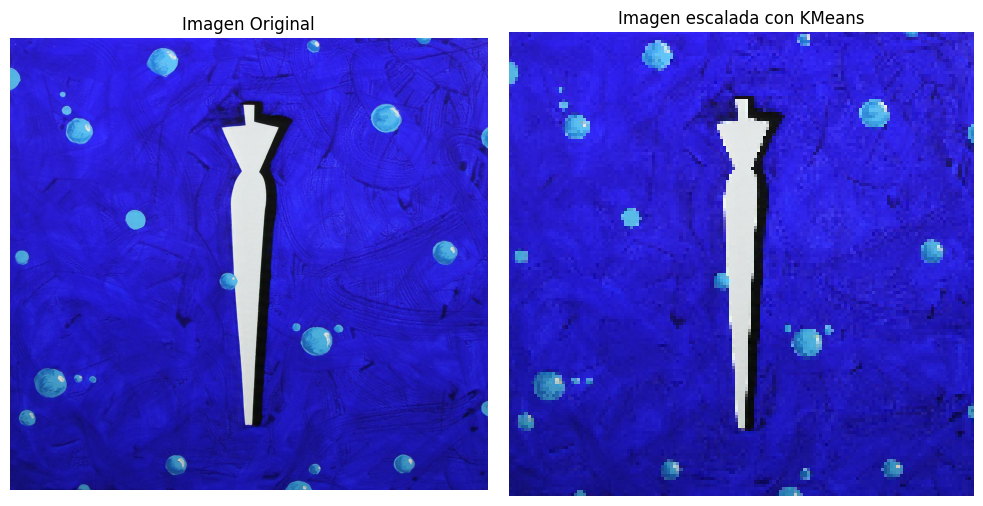

In [103]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_list[image_number])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen escalada')
plt.imshow(img_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

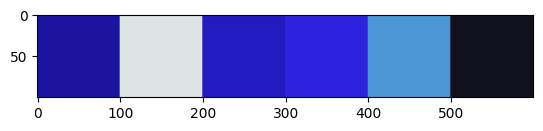

In [104]:
whiteblankimage = 255 * np.ones(shape=[100, 100*len(centroids_scaled), 3], dtype=np.uint8)

for i, color in enumerate(centroids_scaled):
    cv2.rectangle(whiteblankimage, pt1=(i*100,0), pt2=((i+1)*100,200), color=color, thickness=-1)

plt.imshow(whiteblankimage)

plt.show()